In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import cache_magic
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.target import NearConstantVelocityTarget
from tracking_v2.kalman import LinearKalmanFilter, GatedFilter
from tracking_v2.motion import ConstantVelocityModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import Runner, before_one, after_one, before_many, after_many, after_update, evaluate_runner, plot_nscore, plot_runs, plot_2d

from tracking_v2.util import to_df, display
import IPython.display as ipython

In [4]:
display.as_png = True

In [5]:
class GatedRunner(Runner):
    @after_update
    def collect_meas_noise(self, m):
        self.one_noise.append(m.error)

    @before_many
    def prepare_trace(self):
        self.many_gates = []
        self.many_noise = []
        
    @before_one
    def prepare_one_noise(self):
        self.one_noise = []
    
    @after_one
    def collect_run(self):
        if hasattr(self.kf, 'gates'):
            self.many_gates.append(np.asarray(self.kf.gates))
        self.many_noise.append(np.asarray(self.one_noise))
    
    @after_many
    def finalize_trace(self):
        self.many_gates = np.asarray(self.many_gates)
        self.many_noise = np.asarray(self.many_noise)
    
def _cv(q):
    motion = ConstantVelocityModel(q)
    return LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                       [0, 1, 0, 0, 0, 0],
                                       [0, 0, 1, 0, 0, 0]])

def _gated_cv(q, max_chi_sq):
    return GatedFilter(_cv(q), max_chi_sq)

def _run_cv(kf, noise_intensity, m=100, n=500, T=1, seeds=None):
    target = NearConstantVelocityTarget(noise_intensity=noise_intensity)
    sensor = GeometricSensor()
    
    r = GatedRunner(target, sensor, kf)
    r.run_many(m, n, T, seeds=seeds)
    return r

In [6]:
r1 = _run_cv(_cv(1), 1)
e1 = evaluate_runner(r1)

In [7]:
gate = sp.stats.chi2.ppf(0.99, 3)
print(gate)

kf = _gated_cv(1, gate)
r2 = _run_cv(kf, 1)
e2 = evaluate_runner(r2)

11.344866730144373


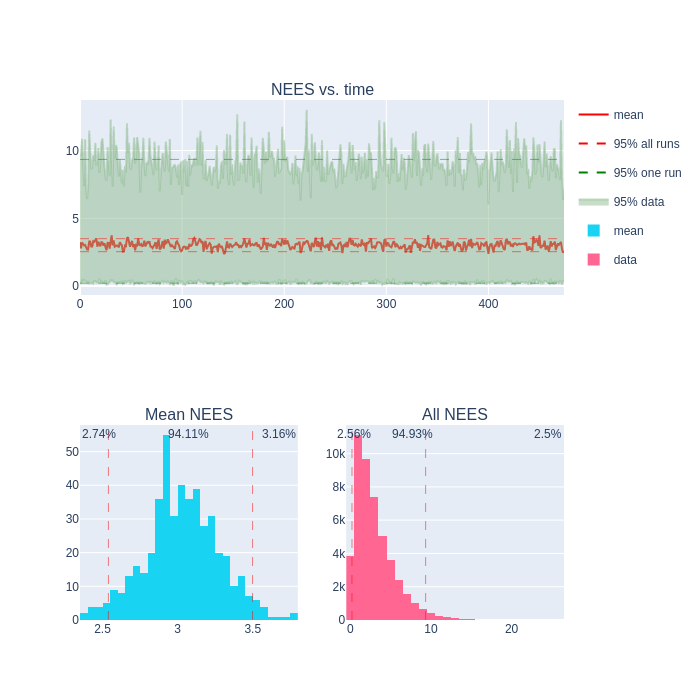

In [8]:
display(plot_nscore(e1.position_nees))

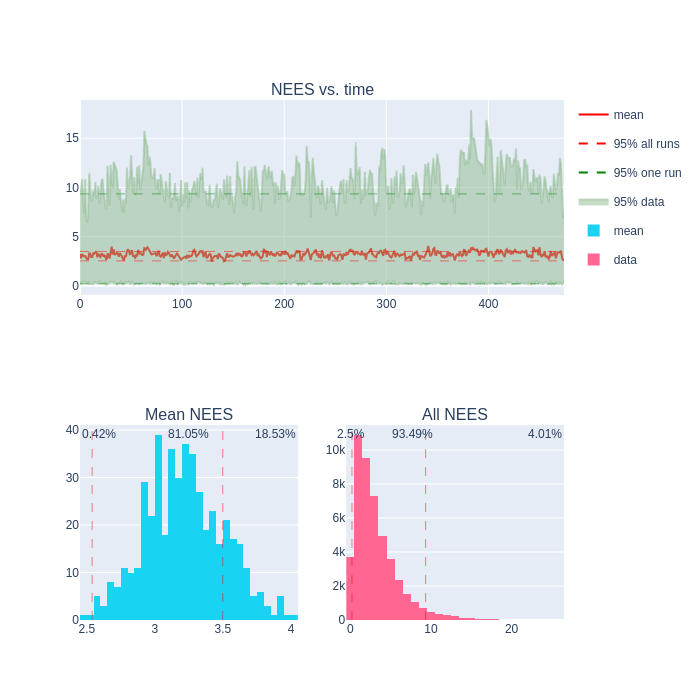

In [9]:
display(plot_nscore(e2.position_nees))

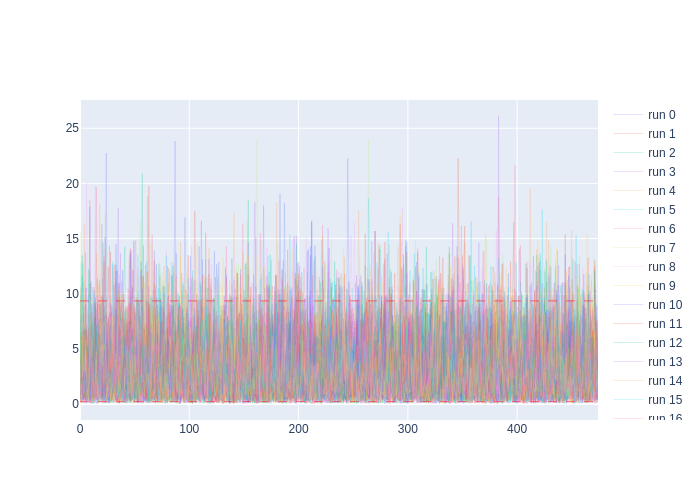

In [10]:
display(plot_runs(e1.position_nees))

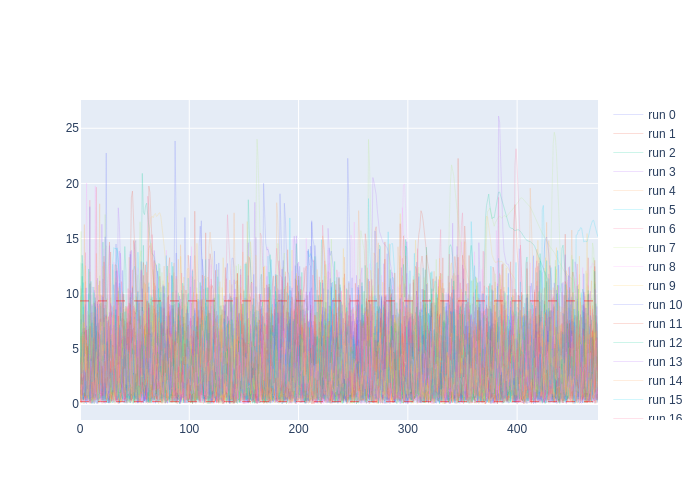

In [11]:
display(plot_runs(e2.position_nees))

In [12]:
gate = sp.stats.chi2.ppf(0.975, 3)
print(gate)

kf = _gated_cv(1, gate)
r3 = _run_cv(kf, 1)
e3 = evaluate_runner(r3)

9.348403604496148


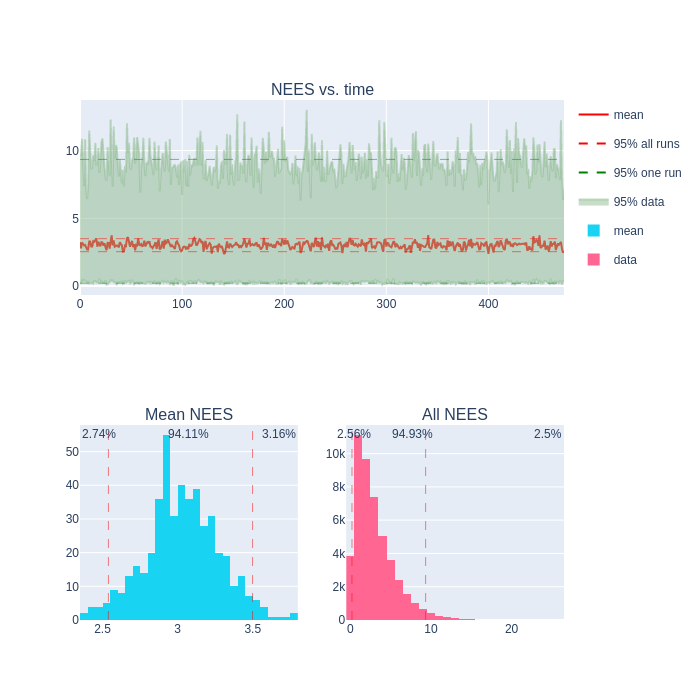

In [13]:
display(plot_nscore(e1.position_nees))

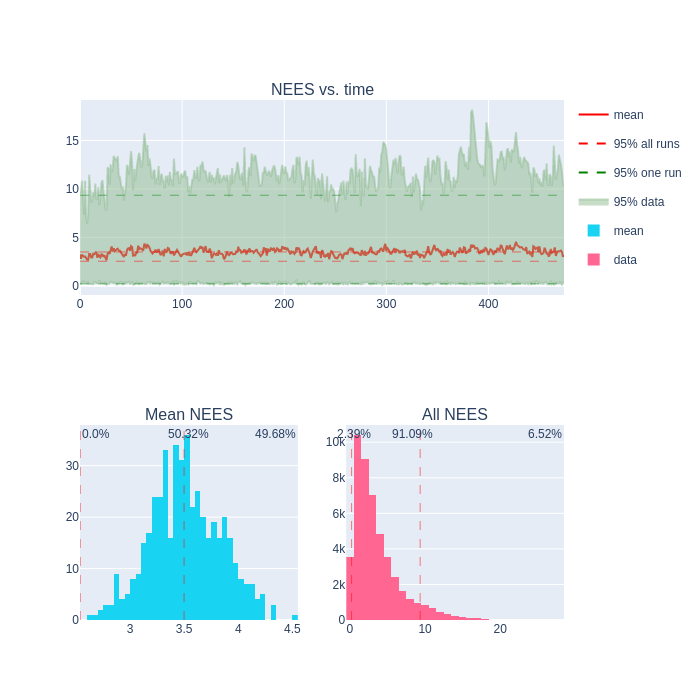

In [14]:
display(plot_nscore(e3.position_nees))

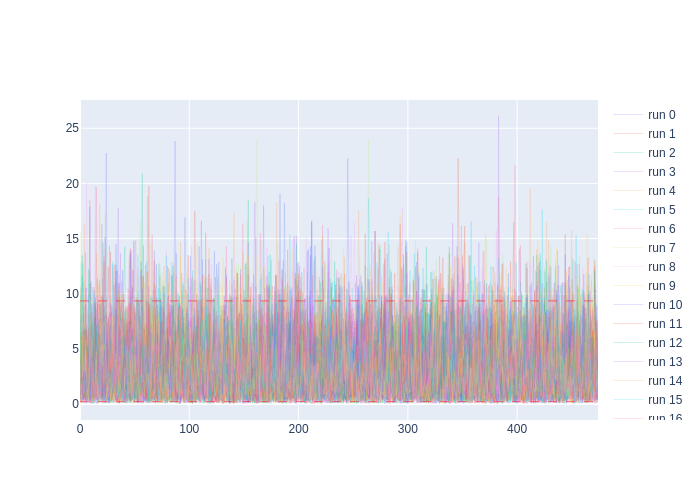

In [15]:
display(plot_runs(e1.position_nees))

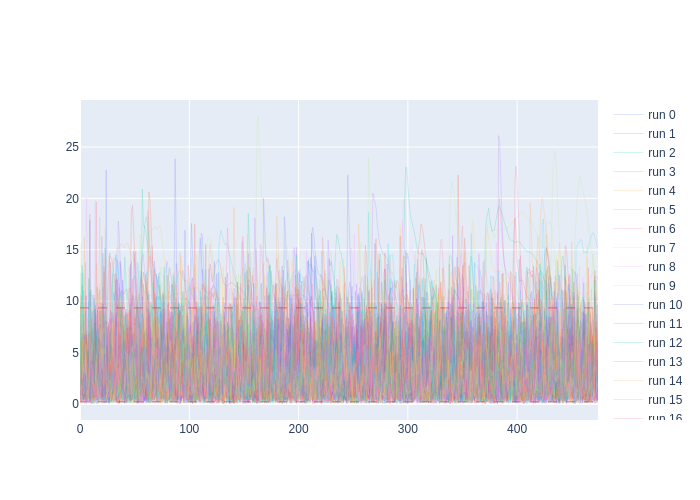

In [16]:
display(plot_runs(e3.position_nees))

In [17]:
gate = sp.stats.chi2.ppf(0.95, 3)
print(gate)

kf = _gated_cv(1, gate)
r4 = _run_cv(kf, 1)
e4 = evaluate_runner(r4)

7.814727903251179


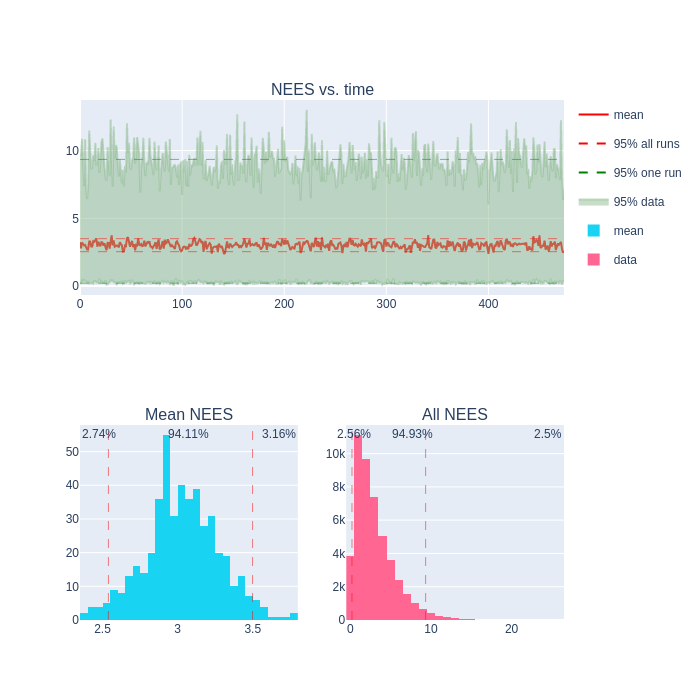

In [18]:
display(plot_nscore(e1.position_nees))

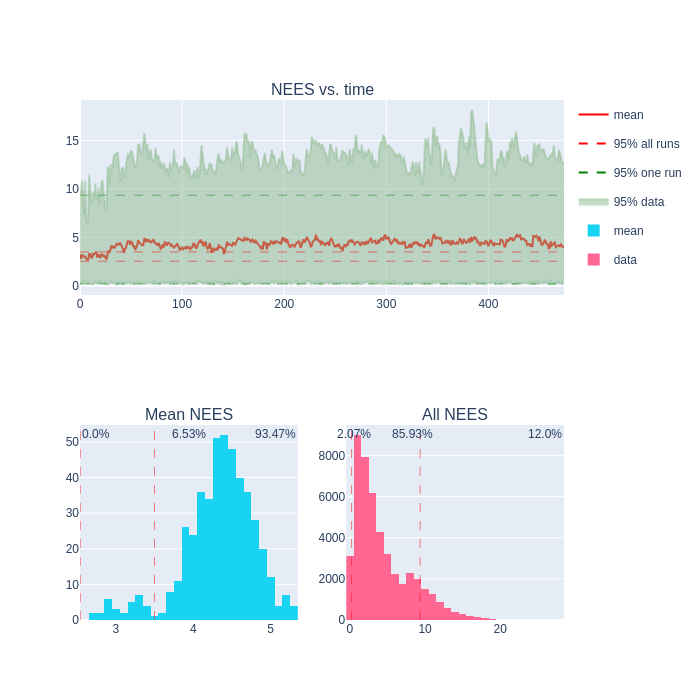

In [19]:
display(plot_nscore(e4.position_nees))

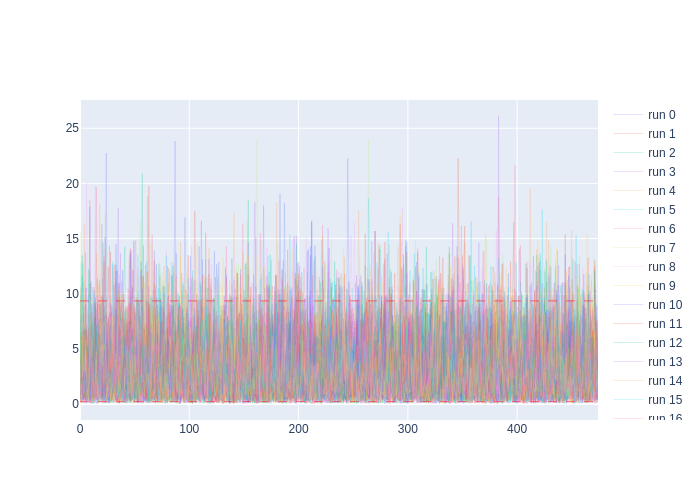

In [20]:
display(plot_runs(e1.position_nees))

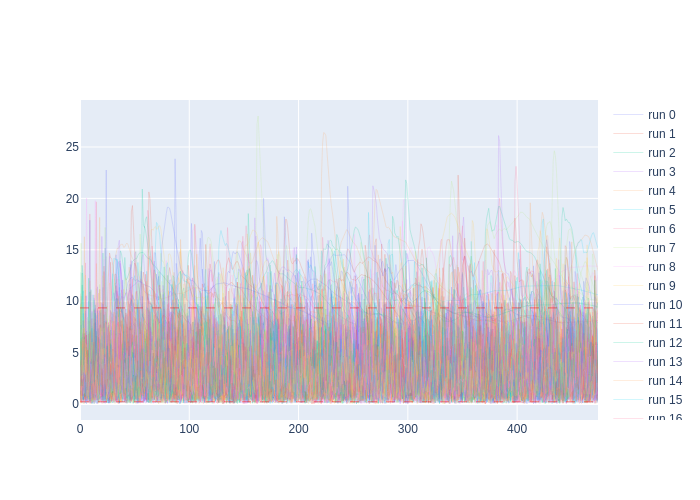

In [21]:
display(plot_runs(e4.position_nees))

In [22]:
rT = _run_cv(_cv(1), 1, T=5)
eT = evaluate_runner(rT)

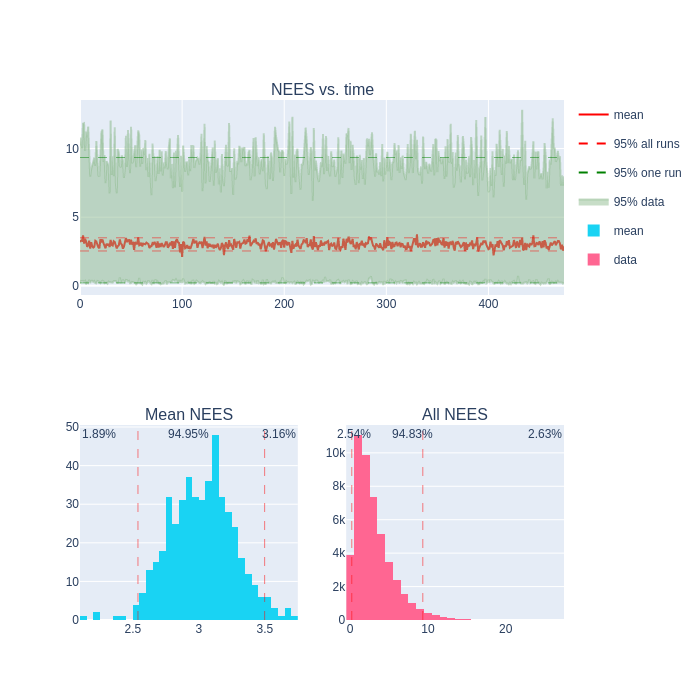

In [23]:
display(plot_nscore(eT.position_nees))

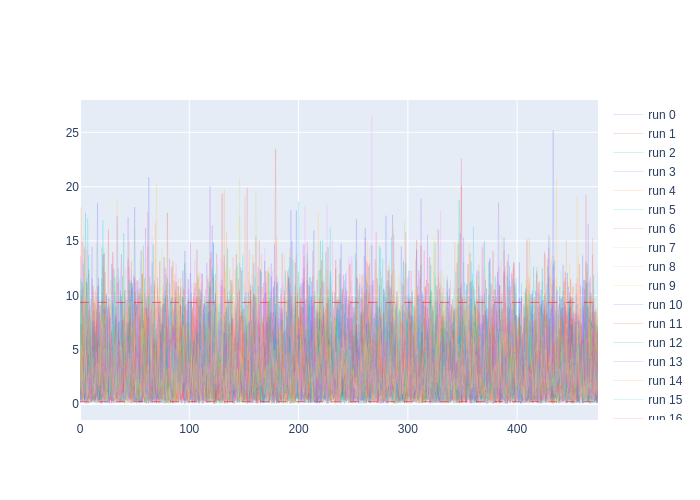

In [24]:
display(plot_runs(eT.position_nees))

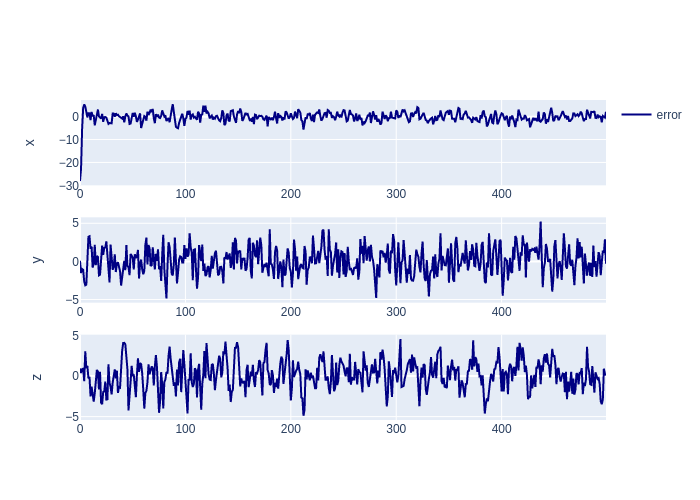

In [25]:
display(plot_2d(r1, residual=True))

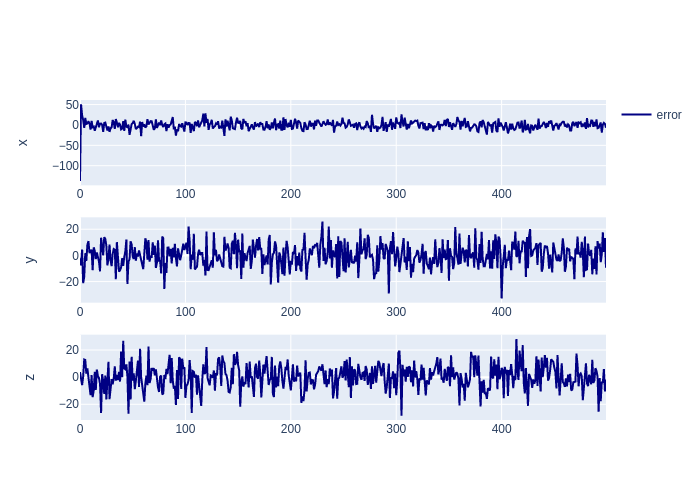

In [26]:
display(plot_2d(rT, residual=True))

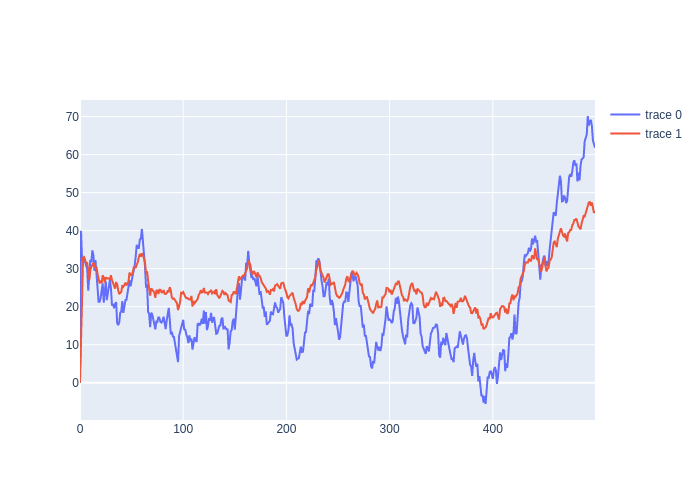

In [27]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=rT.one_x_hat[:,3,0]))
fig.add_trace(go.Scatter(y=r1.one_x_hat[:,3,0]))
display(fig)

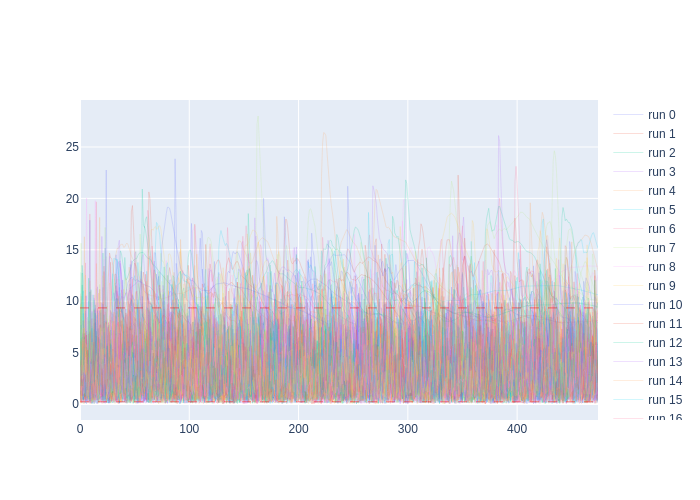

In [28]:
display(plot_runs(e4.position_nees))

In [29]:
seeds = [2]

r1 = _run_cv(_cv(1), 1, m=1, seeds=seeds)

gate = sp.stats.chi2.ppf(0.99, 3)
print(gate)
r2 = _run_cv(_gated_cv(1, gate), 1, m=1, seeds=seeds)

e1 = evaluate_runner(r1)
e2 = evaluate_runner(r2)

11.344866730144373


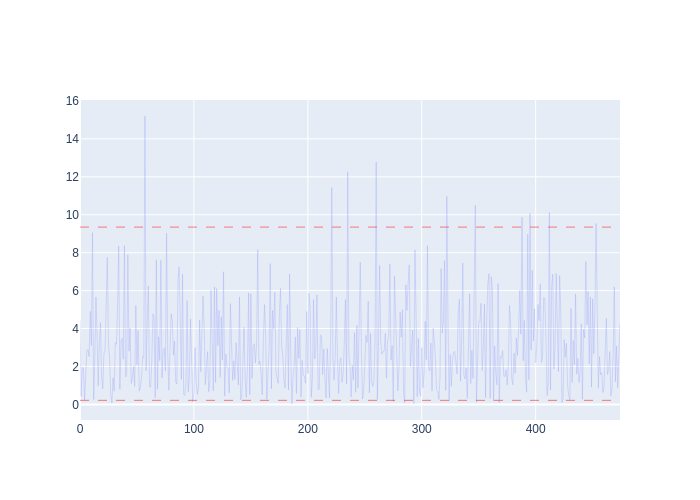

In [30]:
display(plot_runs(e1.position_nis))

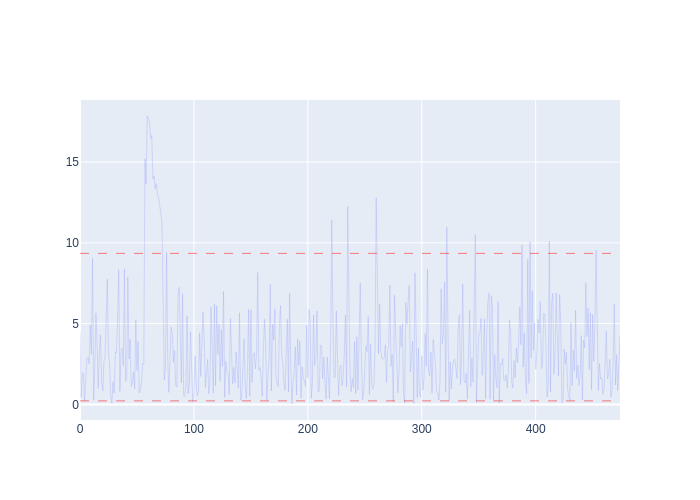

In [31]:
display(plot_runs(e2.position_nis))

When a gate is used, and a measurement with a large error is made, that measurement is rejected due to large NIS. This causes the estimated trajectory (estimates of position and velocity over time) to diverge from the target trajectory: the direction estimated from the last accepted measurement is extrapolated for a few iterations, until the target veers back towards the track. When that happens, and the measurement error puts the measurement closes enough to the track, its NIS is once again below the gate threshold and the track "picks up" measurements once again.

In [32]:
run = 0
start = 0
stop  = 150

x = np.vstack((np.arange(start, stop),
                 np.sqrt(np.sum(np.power(r2.many_x_hat[run,start:stop,:3,0] - r2.many_truth[run,(start+1):(stop+1),:3], 2), axis=1)),
                 r2.many_gates[run,start:stop,0],
                 r2.many_gates[run,start:stop,1],
                 e2.position_nis.scores[run,start:stop],
                 np.sqrt(np.sum(np.power(r2.many_noise[run,start:stop,:,:], 2), axis=2)).squeeze(),
                 np.sqrt(np.sum(np.power(r1.many_x_hat[run,start:stop,:3,0] - r1.many_truth[run,(start+1):(stop+1),:3], 2), axis=1)),
                 e1.position_nis.scores[run,start:stop]
                )).T

with pd.option_context('display.max_rows', None):
    ipython.display(to_df(x, columns=['time', 'r2_err', 'r2_gate', 'r2_update', 'r2_nis', 'noise', 'r1_err', 'r1_nis']))

time      r2_err     r2_gate  r2_update      r2_nis     noise  \
0      0.0   28.606228  218.644253        1.0  218.644253  2.033697   
1      1.0   26.825504  178.193470        1.0  178.193470  2.177793   
2      2.0    9.579181   21.717000        1.0   21.717000  0.410135   
3      3.0    3.110063    1.730267        1.0    1.730267  1.220392   
4      4.0    5.173854    6.989025        1.0    6.989025  0.640045   
5      5.0    4.011132    7.695650        1.0    7.695650  1.934736   
6      6.0    2.211789    2.207558        1.0    2.207558  0.822209   
7      7.0    1.489044    2.425954        1.0    2.425954  2.498817   
8      8.0    3.917857    5.716165        1.0    5.716165  0.972433   
9      9.0    2.804811    1.104446        1.0    1.104446  1.412732   
10    10.0    5.103715    4.502952        1.0    4.502952  1.024771   
11    11.0    3.313946    3.412554        1.0    3.412554  2.136155   
12    12.0    3.974304    3.348846        1.0    3.348846  1.410323   
13    13.0    1.872098    0.640973        1.0    0.640973  1.311826   
14    14.0    2.703076    3.263529        1.0    3.263529  1.400631   
15    15.0    2.912838    2.451222        1.0    2.451222  0.933794   
16    16.0    2.326570    0.992628        1.0    0.992628  1.043926   
17    17.0    2.732708    2.555949        1.0    2.555949  0.794056   
18    18.0    1.876921    0.337744        1.0    0.337744  0.757750   
19    19.0    1.995519    0.250955        1.0    0.250955  1.905220   
20    20.0    2.942829    3.904760        1.0    3.904760  2.471321   
21    21.0    3.957497    6.414496        1.0    6.414496  2.155106   
22    22.0    3.023264    3.247165        1.0    3.247165  1.027058   
23    23.0    1.875771    1.900573        1.0    1.900573  2.349612   
24    24.0    4.767101    6.627048        1.0    6.627048  0.508553   
25    25.0    3.298383    4.430521        1.0    4.430521  1.363166   
26    26.0    1.528664    0.418308        1.0    0.418308  0.964047   
27    27.0    2.692886    1.956735        1.0    1.956735  2.031805   
28    28.0    2.295842    1.922419        1.0    1.922419  0.787835   
29    29.0    2.300878    0.215076        1.0    0.215076  1.607268   
30    30.0    2.694415    1.530774        1.0    1.530774  1.548533   
31    31.0    2.775440    2.823630        1.0    2.823630  1.095483   
32    32.0    1.632543    2.911487        1.0    2.911487  2.087568   
33    33.0    2.793353    2.523343        1.0    2.523343  1.289573   
34    34.0    3.484568    4.899618        1.0    4.899618  2.093807   
35    35.0    4.472500    3.101275        1.0    3.101275  2.116893   
36    36.0    5.264886    9.054556        1.0    9.054556  1.584399   
37    37.0    1.982177    0.256621        1.0    0.256621  1.623007   
38    38.0    2.273581    2.448619        1.0    2.448619  2.471906   
39    39.0    4.353096    5.664560        1.0    5.664560  1.556447   
40    40.0    3.474425    3.675192        1.0    3.675192  0.689212   
41    41.0    1.137902    0.982443        1.0    0.982443  1.202426   
42    42.0    1.871885    3.273663        1.0    3.273663  2.466125   
43    43.0    4.427475    4.312823        1.0    4.312823  0.527744   
44    44.0    2.754009    1.402018        1.0    1.402018  0.999782   
45    45.0    2.821948    0.821249        1.0    0.821249  1.471141   
46    46.0    3.904770    2.680982        1.0    2.680982  1.294571   
47    47.0    3.302745    2.844932        1.0    2.844932  0.199047   
48    48.0    3.641209    5.231421        1.0    5.231421  2.622806   
49    49.0    4.122332    7.752363        1.0    7.752363  1.645424   
50    50.0    2.713495    3.191688        1.0    3.191688  2.012472   
51    51.0    2.677563    2.452492        1.0    2.452492  0.684709   
52    52.0    0.586382    0.512134        1.0    0.512134  1.222585   
53    53.0    2.487545    0.068903        1.0    0.068903  2.969041   
54    54.0    3.435829    1.398885        1.0    1.398885  2.332953   
55    55.0    3.227986    0.70